The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


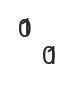

In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import reconstruction_accuracy, VAELoss
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullFVAE
from src.datasets import CDR3BetaDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

# Some checks

In [50]:
for i in range(5):
    print(f'\n{i}')
    %cat ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/args_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.txt | tail -n 10


0
Fold: 0Best valid epoch: 575
total:	0.4113215639264493
reconstruction:	0.37363986051697323
kld:	0.037681700979748246
seq_accuracy:	0.9379920959472656
v_accuracy:	0.9218271970748901
j_accuracy:	0.99434894323349
Fold: 0Best valid seq acc: 0.9381558377693086
Best valid V acc: 0.9215917117965623
Best valid J acc: 0.993407110901813

1
Fold: 1Best valid epoch: 674
total:	0.6807788295862699
reconstruction:	0.6456284207852802
kld:	0.0351504118170354
seq_accuracy:	0.9561837315559387
v_accuracy:	0.8152686357498169
j_accuracy:	0.9957587122917175
Fold: 1Best valid seq acc: 0.9566856574804349
Best valid V acc: 0.819038642789821
Best valid J acc: 0.9957587181903864

2
Fold: 2Best valid epoch: 795
total:	0.7249003094413676
reconstruction:	0.6897032166819129
kld:	0.03519708667349759
seq_accuracy:	0.9577098488807678
v_accuracy:	0.8235571384429932
j_accuracy:	0.9955241680145264
Fold: 2Best valid seq acc: 0.9571465191206466
Best valid V acc: 0.8235571260306243
Best valid J acc: 0.9967020023557126

3
F

Probly don't need to have that much weight on J gene but for V gene 2.5 seems good.

In [33]:
%ls ../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k

FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.png
args_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.txt
checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pt
train_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
train_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_losses_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_metrics_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.pkl
valid_predictions_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230926_1923_bb76k.csv


In [27]:
# init stuff
kcv_df = pd.read_csv('../data/filtered/230921_nettcr_immrepnegs_noswap.csv')
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')
# Re-init / write down params here ; Taken from the args.txt
max_len, encoding, pad_scale = 23, 'BL50LO', -20
cdr3b_col, v_col, j_col = 'B3', 'TRBV_gene', 'TRBJ_gene'
use_v, use_j, v_dim, j_dim = True, True, 51, 13
hidden_dim, latent_dim = 256, 128
lr, weight_decay = 5e-4, 1e-4
loss_weights = {'weight_seq':3, 'weight_kld':1, 'weight_v':2.5, 'weight_j':2}
n_epochs, batch_size = 2000, 256
# Remaking dataset-loaders
total_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map=None, j_map = None)
total_loader = total_dataset.get_dataloader(batch_size, RandomSampler)
test_dataset = CDR3BetaDataset(kcv_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map= total_dataset.v_map, j_map = total_dataset.j_map)
test_loader = test_dataset.get_dataloader(batch_size, SequentialSampler)
folder = '../output/FirstTest_230926_1923_bb76k/'

In [ ]:
# Turns out, I didn't think that different partitions in the train dataset would have different v/j maps.
# As such, I need to save it here and reload it everytime (HARDCODED BAD BEHAVIOUR BUT NO WORKAROUND BECAUSE I NEED TO MAKE SURE THINGS MATCH BETWEEN FOLDS)
# Also need to fix the weights on seq/kld/v/j weights to 3, 2, 2.5, 1.5 ; For now, re-run the scripts and test stuff here and do inference.

In [44]:
pkl_dump(total_dataset.v_map, '../data/Matrices/230927_nettcr_dataset_vmap.pkl')
pkl_dump(total_dataset.j_map, '../data/Matrices/230927_nettcr_dataset_jmap.pkl')

/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_vmap.pkl saved.
/Users/riwa/Documents/code/tclustr/data/Matrices/230927_nettcr_dataset_jmap.pkl saved.


# Reloading models and preds from KCV

In [25]:
len(kcv_df.TRBV_gene.unique())

51

In [45]:
models = {}
for i in range(5):
    fn = f'{folder}FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k/checkpoint_best_fold{i:02}_kcv_230921_nettcr_immrepnegs_noswap_f{i:02}_FirstTestKFOLD_bb76k_KFold_{i}_230926_1923_bb76k.pt'
    try:
        models[i] = load_checkpoint(FullFVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)
    except:
        print(i)
        d = torch.load(fn)
        print(d['encoder.0.weight'].shape)
    # might as well retrain all folds with adjusted v/j/kld weights

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
0
torch.Size([261, 523])
odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder_mu.weight', 'encoder_mu.bias', 'encoder_logvar.weight', 'encoder_logvar.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder_sequence.0.weight', 'decoder_sequence.0.bias', 'decoder_sequence.2.weight', 'decoder_sequence.2.bias', 'decoder_v.weight', 'decoder_v.bias', 'decoder_j.weight', 'decoder_j.bias'])
3
torch.Size([261, 523])


# Fixing the seq recons accuracy taking the pad instead of the actual sequence with the true lengths

In [72]:
sample = test_dataset.x[:5]
x_hat, _, _ = models[1](sample)


In [129]:
# Redo accuracy without padding
seq_true, v_true, j_true = models[1].reconstruct_hat(sample)
seq_hat, v_hat, j_hat = models[1].reconstruct_hat(x_hat)
# randomly change some indices so acc is not 100%
seq_hat[0,5:7]=3
seq_hat[1,6]=12
seq_hat[2, 0:7]=4

In [143]:
# NOTE : Fixed version with the true acc
def redo_acc(seq_true, seq_hat, v_true, v_hat, j_true, j_hat, pad_index=20, return_per_element=False):

    mask = (seq_true != pad_index).float()
    true_lens = mask.sum(dim=1)
    # masked_seq_true = seq_true*mask
    # masked_seq_hat = seq_hat*mask
    # difference here for per element is that we don't take the mean(dim=0) and have to detach() from graph to do tolist()
    seq_accuracy = ((seq_true == seq_hat).float() * mask).sum(1) / true_lens
    print(true_lens)
    print(mask)
    if return_per_element:
        seq_accuracy = seq_accuracy.detach().cpu().tolist()
        v_accuracy = ((v_true.argmax(dim=1) == v_hat.argmax(dim=1)).float()).detach().cpu().int().tolist()
        j_accuracy = ((j_true.argmax(dim=1) == j_hat.argmax(dim=1)).float()).detach().cpu().int().tolist()
    else:
        seq_accuracy = seq_accuracy.mean(dim=0).item()
        v_accuracy = ((v_true.argmax(dim=1) == v_hat.argmax(dim=1)).float().mean(dim=0)).item()
        j_accuracy = ((j_true.argmax(dim=1) == j_hat.argmax(dim=1)).float().mean(dim=0)).item()
    return seq_accuracy, v_accuracy, j_accuracy
redo_acc(seq_true, seq_hat, v_true, v_hat, j_true, j_hat, 20, True)[0]

tensor([10., 12., 13., 13., 13.])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])


[0.800000011920929, 0.9166666865348816, 0.38461539149284363, 1.0, 1.0]

In [109]:
((seq_true==seq_hat).float() * mask).sum(1) / true_lengths

tensor([0.8000, 0.9167, 0.3846, 1.0000, 1.0000])

In [107]:
# Create a binary mask where 1 indicates non-padding values
mask = (seq_true != 20).float()

# Sum along the columns to get the true length for each row
true_lengths = mask.sum(dim=1)
# Apply the mask to both seq_true and seq_hat
masked_seq_true = seq_true * mask
masked_seq_hat = seq_hat * mask

# Calculate element-wise equality
reconstruction_accuracy = ((masked_seq_true == masked_seq_hat).float() * mask).sum(1) / true_lengths
reconstruction_accuracy

tensor([0.8000, 0.9167, 0.3846, 1.0000, 1.0000])

In [97]:
true_lengths

tensor([10., 12., 13., 13., 13.])

# inference using the reloaded models (missing 2 folds) 230927_1009

In [200]:
%ls ../output/FirstTest_230926_1923_bb76k/

FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/
FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/
FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/
FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/
FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/


In [205]:
next(filter(lambda x:'checkpoint' in x, os.listdir(fdir[0])))

'checkpoint_best_fold04_kcv_230921_nettcr_immrepnegs_noswap_f04_FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k.pt'

In [206]:
sorted(fdir)

['../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/',
 '../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/']

In [238]:
# reload all models now : 
maindir='../output/FirstTest_230926_1923_bb76k/'
fdirs = sorted([(f'{maindir}{x}'+'/').replace('//','/') for x in os.listdir(maindir) if x !='.DS_Store'])
models = {}
for i,fd in enumerate(fdirs):
    fn = f"{fd}{next(filter(lambda x:'checkpoint' in x, os.listdir(fd)))}"
    print(fn)
    models[i] = load_checkpoint(FullFVAE(max_len, encoding, pad_scale, 20, use_v, use_j, v_dim, j_dim, nn.SELU(), hidden_dim, latent_dim), fn)

../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k/checkpoint_best_fold00_kcv_230921_nettcr_immrepnegs_noswap_f00_FirstTestKFOLD_bb76k_KFold_0_230927_1014_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k/checkpoint_best_fold01_kcv_230921_nettcr_immrepnegs_noswap_f01_FirstTestKFOLD_bb76k_KFold_1_230926_1923_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k/checkpoint_best_fold02_kcv_230921_nettcr_immrepnegs_noswap_f02_FirstTestKFOLD_bb76k_KFold_2_230926_1923_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k/checkpoint_best_fold03_kcv_230921_nettcr_immrepnegs_noswap_f03_FirstTestKFOLD_bb76k_KFold_3_230927_1014_bb76k.pt
../output/FirstTest_230926_1923_bb76k/FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k/checkpoint_best_fold04_kcv_230921_nettcr_immrepnegs_noswap_f04_FirstTestKFOLD_bb76k_KFold_4_230926_1923_bb76k.pt


In [239]:
from src.data_processing import AA_KEYS
test_df = pd.read_csv('../data/filtered/230921_vdjdb_mcpas_filtered_concat_cdr3b_vjgenes')
test_df['flag'] = test_df['B3'].apply(lambda x: all([c in AA_KEYS for c in x]))
# Some filtering that I forgot to do before...
test_df = test_df.query('flag')
test_df = test_df.query('TRBV_gene in @V_MAP.keys() and TRBJ_gene in @J_MAP.keys()')
test_df = test_df.query('B3 not in @kcv_df.B3.unique()')
# Re-saving the filtered test set
test_df.to_csv('../data/filtered_230927_vdjdb_mcpas_filtered_concat_REDONE_cdr3b_vjgenes.csv', index=False)
test_dataset = CDR3BetaDataset(test_df, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
test_loader = test_dataset.get_dataloader(1024, SequentialSampler)

In [240]:
from src.metrics import reconstruction_accuracy
from src.data_processing import V_MAP, J_MAP
from src.datasets import CDR3BetaDataset

df_valid_0 = kcv_df.query('partition==0')
valid_dataset_0 = CDR3BetaDataset(df_valid_0, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_0 = valid_dataset_0.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_1 = kcv_df.query('partition==1')
valid_dataset_1 = CDR3BetaDataset(df_valid_1, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_1 = valid_dataset_1.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_2 = kcv_df.query('partition==2')
valid_dataset_2 = CDR3BetaDataset(df_valid_2, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_2 = valid_dataset_2.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_3 = kcv_df.query('partition==3')
valid_dataset_3 = CDR3BetaDataset(df_valid_3, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_3 = valid_dataset_3.get_dataloader(batch_size=1024, sampler=SequentialSampler)

df_valid_4 = kcv_df.query('partition==4')
valid_dataset_4 = CDR3BetaDataset(df_valid_4, max_len, encoding, pad_scale, cdr3b_col, use_v, use_j, v_col, j_col, v_dim, j_dim, v_map = V_MAP, j_map = J_MAP)
valid_loader_4 = valid_dataset_4.get_dataloader(batch_size=1024, sampler=SequentialSampler)

# Re-get predictions so that we get the correct accuracy now with the updated non-pad seq reconstruction accuracy
torch.manual_seed(0)
df_valid_0 = predict_model(models[0], valid_dataset_0, valid_loader_0)
df_test_0 = predict_model(models[0], test_dataset, test_loader)
torch.manual_seed(1)
df_valid_1 = predict_model(models[1], valid_dataset_1, valid_loader_1)
df_test_1 = predict_model(models[1], test_dataset, test_loader)
torch.manual_seed(2)
df_valid_2 = predict_model(models[2], valid_dataset_2, valid_loader_2)
df_test_2 = predict_model(models[2], test_dataset, test_loader)
torch.manual_seed(3)
df_valid_3 = predict_model(models[3], valid_dataset_3, valid_loader_3)
df_test_3 = predict_model(models[3], test_dataset, test_loader)
torch.manual_seed(4)
df_valid_4 = predict_model(models[4], valid_dataset_4, valid_loader_4)
df_test_4 = predict_model(models[4], test_dataset, test_loader)

del valid_dataset_0, valid_loader_0, valid_dataset_1, valid_loader_1, valid_dataset_2, valid_loader_2, valid_dataset_3, valid_loader_3, valid_dataset_4, valid_loader_4, test_dataset, test_loader

In [243]:
for fd, valid, test in zip(fdirs, [df_valid_0, df_valid_1, df_valid_2, df_valid_3, df_valid_4], [df_test_0, df_test_1, df_test_2, df_test_3, df_test_4]):
    valid.to_csv(f'{fd}redo_valid.csv',index=False)
    test.to_csv(f'{fd}redo_test.csv',index=False)

In [244]:
for df, n in zip([df_valid_0, df_valid_1, df_valid_2, df_valid_3, df_valid_4, df_test_0, df_test_1, df_test_2, df_test_3, df_test_4],
                 ["z_valid_0", "z_valid_1", "z_valid_2", "z_valid_3", "z_valid_4", "z_test_0", "z_test_1", "z_test_2", "z_test_3", "z_test_4"]):
    print(n)
    print(f'Seq {df.seq_acc.mean():.2%}, V {df.v_correct.mean():.2%}, J {df.j_correct.mean():.2%}')


z_valid_0
Seq 91.40%, V 99.08%, J 99.34%
z_valid_1
Seq 92.90%, V 98.75%, J 99.62%
z_valid_2
Seq 93.22%, V 99.15%, J 99.69%
z_valid_3
Seq 92.27%, V 98.94%, J 99.22%
z_valid_4
Seq 91.89%, V 99.39%, J 99.03%
z_test_0
Seq 90.19%, V 98.12%, J 97.91%
z_test_1
Seq 91.48%, V 98.06%, J 98.38%
z_test_2
Seq 92.01%, V 98.46%, J 98.79%
z_test_3
Seq 90.86%, V 98.25%, J 98.11%
z_test_4
Seq 90.61%, V 98.44%, J 98.25%


## clustering stuff

In [1579]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=13)
z_split_train = model_split_optim.embed(x_train).detach().numpy()
z_split_valid = model_split_optim.embed(x_valid).detach().numpy()

# Clustering with K-Means
kmeans = KMeans(n_clusters=26, random_state=13)
train_clusters = kmeans.fit_predict(z_split_train)
valid_clusters = kmeans.predict(z_split_valid)

latent_tsne = tsne.fit_transform(np.concatenate([z_split_train, z_split_valid],axis=0))

latent_train = latent_tsne[:len(z_split_train)]
latent_valid = latent_tsne[len(z_split_train):]
train_plot_df_split = pd.DataFrame(data=np.stack([latent_train[:,0], latent_train[:, 1], train_clusters, train_labels]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
train_plot_df_split['KMeans_Cluster'] = train_plot_df_split['KMeans_Cluster'].astype(str)
valid_plot_df_split = pd.DataFrame(data=np.stack([latent_valid[:,0], latent_valid[:, 1], valid_clusters, valid_labels]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
valid_plot_df_split['KMeans_Cluster'] = valid_plot_df_split['KMeans_Cluster'].astype(str)


tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=13)
z_concat_train = model_concat_optim.embed(x_train).detach().numpy()
z_concat_valid = model_concat_optim.embed(x_valid).detach().numpy()

# Clustering with K-Means
kmeans = KMeans(n_clusters=26, random_state=13)
train_clusters = kmeans.fit_predict(z_split_train)
valid_clusters = kmeans.predict(z_split_valid)

latent_tsne = tsne.fit_transform(np.concatenate([z_concat_train, z_concat_valid],axis=0))

latent_train = latent_tsne[:len(z_concat_train)]
latent_valid = latent_tsne[len(z_concat_train):]
train_plot_df_concat = pd.DataFrame(data=np.stack([latent_train[:,0], latent_train[:, 1], train_clusters, train_labels]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
train_plot_df_concat['KMeans_Cluster'] = train_plot_df_concat['KMeans_Cluster'].astype(str)
valid_plot_df_concat = pd.DataFrame(data=np.stack([latent_valid[:,0], latent_valid[:, 1], valid_clusters, valid_labels]).T, columns = ['TSNE_1', 'TSNE_2', 'KMeans_Cluster', 'GroundTruth'])#.query('GroundTruth in ["immrep_negs" ,"ELAGIGILTV", "RAKFKQLL", "GILGFVFTL", "GLCTLVAML", "YLQPRTFLL", "NLVPMVATV"]')
valid_plot_df_concat['KMeans_Cluster'] = valid_plot_df_concat['KMeans_Cluster'].astype(str)

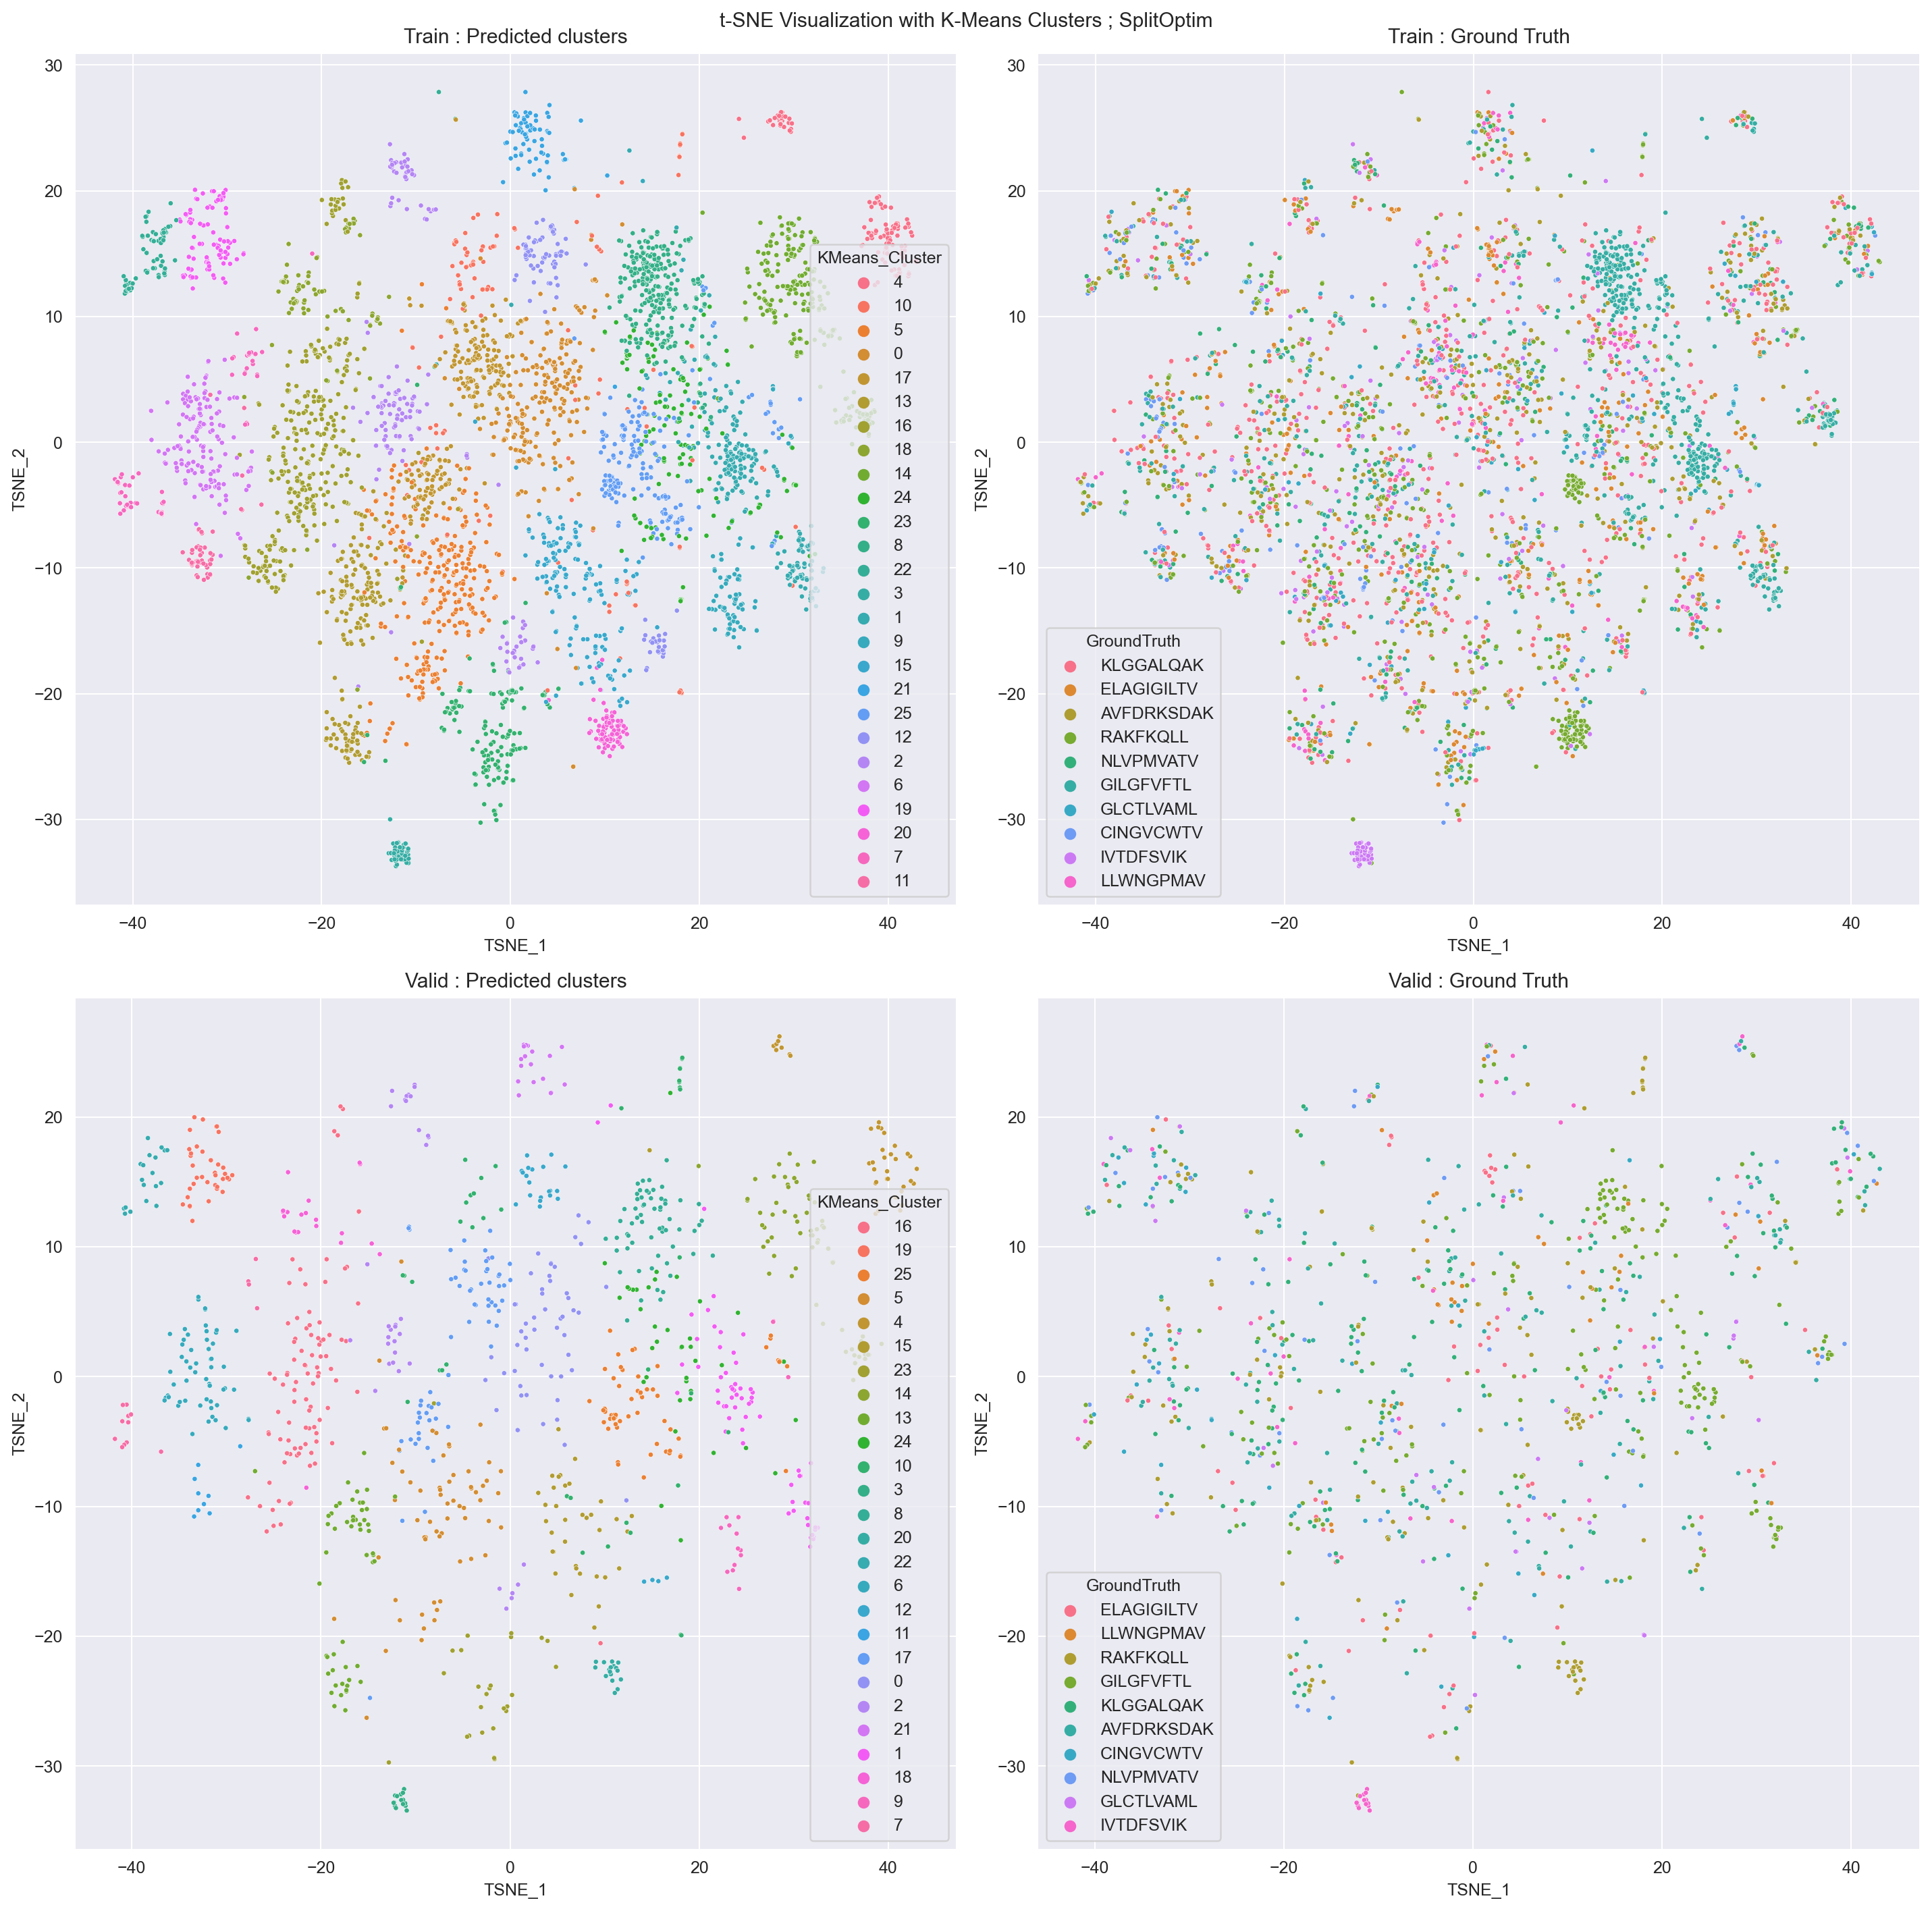

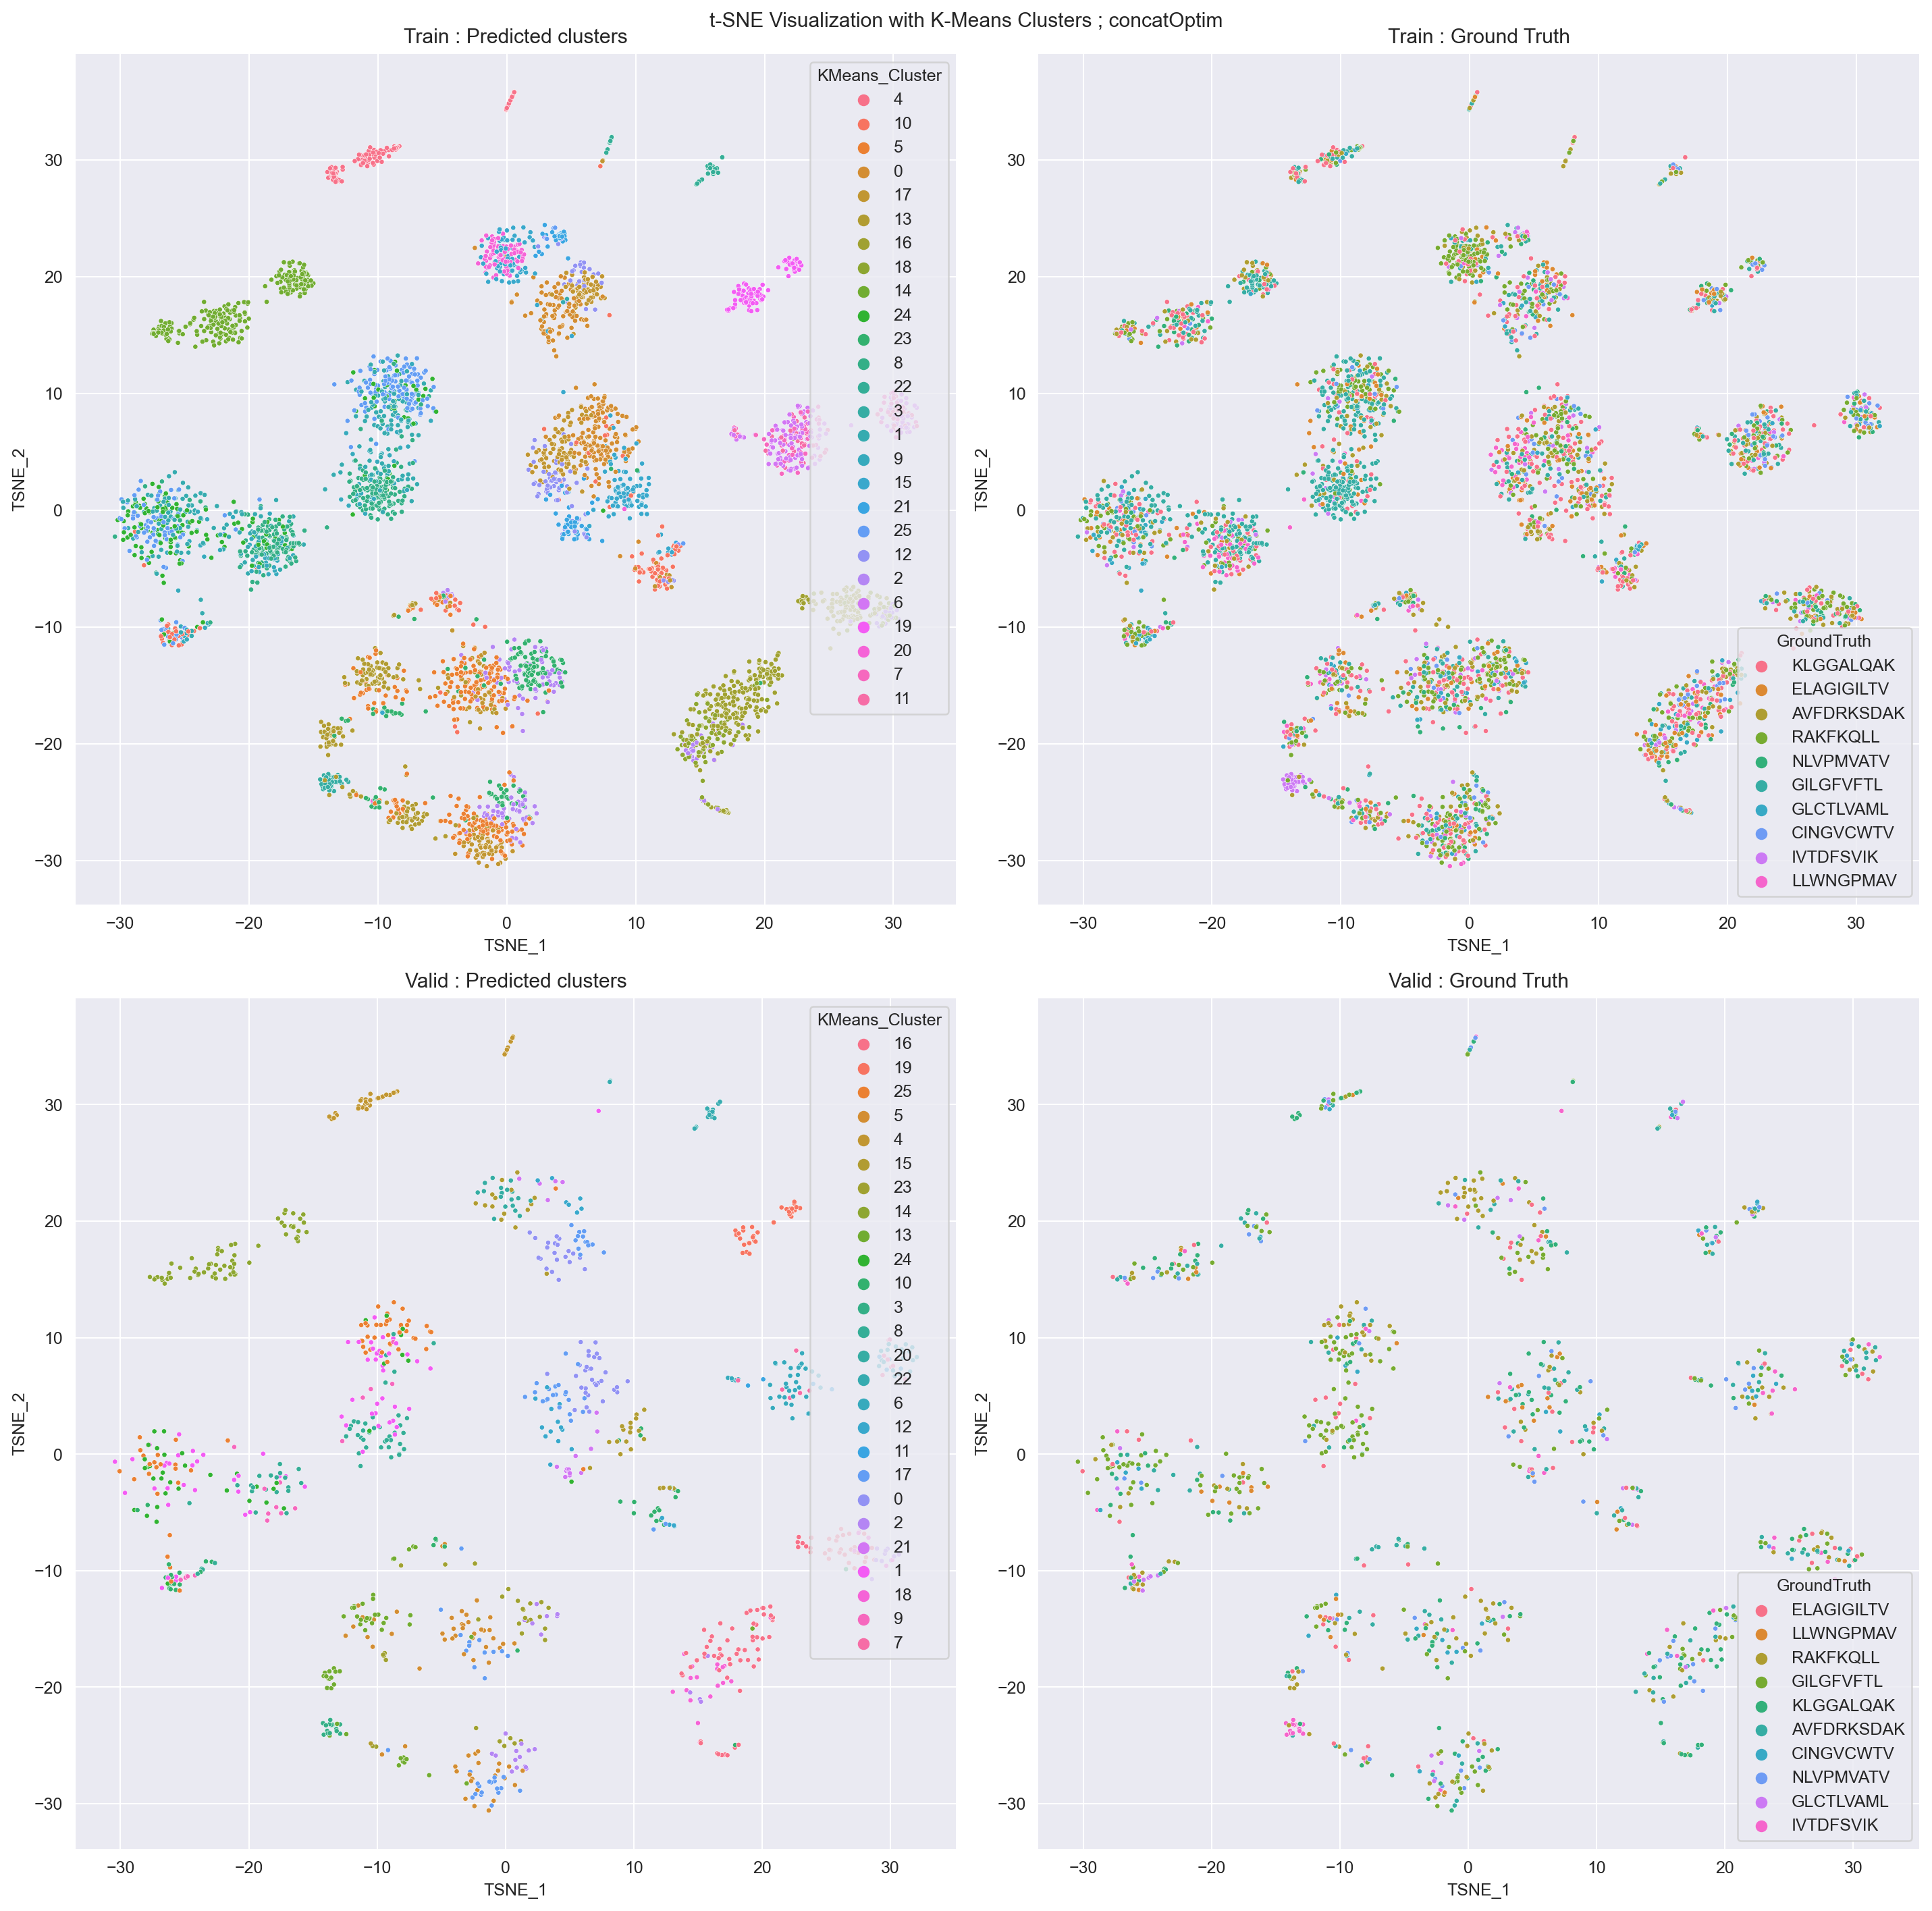

In [1610]:
f,a = plt.subplots(2,2, figsize=(16,16))
sns.set_palette('gnuplot2_r', n_colors=7)
f.suptitle('t-SNE Visualization with K-Means Clusters ; SplitOptim')
a = a.ravel()

top10_peps = train_plot_df_split.groupby(['GroundTruth']).agg(count=('TSNE_1', 'count')).sort_values('count', ascending=False).index[:10]


sns.scatterplot(data=train_plot_df_split.query('GroundTruth in @top10_peps'), x='TSNE_1', y='TSNE_2',  s=8.5, hue='KMeans_Cluster', ax = a[0])
a[0].set_title('Train : Predicted clusters')

sns.scatterplot(data=train_plot_df_split.query('GroundTruth in @top10_peps'), x='TSNE_1', y='TSNE_2',  s=8.5, hue='GroundTruth', ax = a[1])
a[1].set_title('Train : Ground Truth')

sns.scatterplot(data=valid_plot_df_split.query('GroundTruth in @top10_peps'), x='TSNE_1', y='TSNE_2',  s=8.5, hue='KMeans_Cluster', ax = a[2])
a[2].set_title('Valid : Predicted clusters')

sns.scatterplot(data=valid_plot_df_split.query('GroundTruth in @top10_peps'), x='TSNE_1', y='TSNE_2',  s=8.5, hue='GroundTruth', ax = a[3])
a[3].set_title('Valid : Ground Truth')
f.tight_layout()
f.savefig('../output/first_cluster_test_SPLIToptim_kmeans_nonegs.png', bbox_inches='tight',  dpi=200)

f,a = plt.subplots(2,2, figsize=(16,16))
f.suptitle('t-SNE Visualization with K-Means Clusters ; concatOptim')
a = a.ravel()
sns.scatterplot(data=train_plot_df_concat.query('GroundTruth in @top10_peps'), x='TSNE_1', y='TSNE_2',  s=8.5, hue='KMeans_Cluster', ax = a[0])
a[0].set_title('Train : Predicted clusters')

sns.scatterplot(data=train_plot_df_concat.query('GroundTruth in @top10_peps'), x='TSNE_1', y='TSNE_2',  s=8.5, hue='GroundTruth', ax = a[1])
a[1].set_title('Train : Ground Truth')

sns.scatterplot(data=valid_plot_df_concat.query('GroundTruth in @top10_peps'), x='TSNE_1', y='TSNE_2',  s=8.5, hue='KMeans_Cluster', ax = a[2])
a[2].set_title('Valid : Predicted clusters')

sns.scatterplot(data=valid_plot_df_concat.query('GroundTruth in @top10_peps'), x='TSNE_1', y='TSNE_2',  s=8.5, hue='GroundTruth', ax = a[3])
a[3].set_title('Valid : Ground Truth')
f.tight_layout()
f.savefig('../output/first_cluster_test_CONCAToptim_kmeans_nonegs.png', bbox_inches='tight', dpi=200)